In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../../')
import numpy as np
from numpy.random import default_rng

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge
from best_subset import *
from UBIC import *
from solvel0 import solvel0
from findiff import FinDiff

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([-1, -1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

Sklearn's version: 1.2.2
Complete best-subset solvers are not installed.


#### Load data

In [2]:
data = sio.loadmat('../../Datasets/kuramoto_sivishinky.mat')
u = data['uu']
x = data['x'][:,0]
t = data['tt'][0,:]
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

#### Visualization

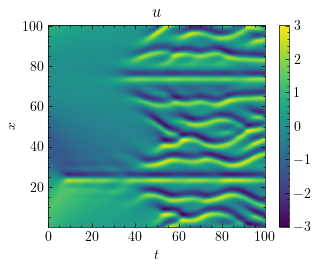

In [3]:
with plt.style.context(['science']):
    ufig, uax = plt.subplots()
    contour = uax.pcolormesh(t, x, u, shading='gouraud')
    uax.set_xlabel("$t$")
    uax.set_ylabel("$x$")
    uax.set_title("$u$")
    cbar = ufig.colorbar(contour)
    plt.show()

#### Add noise

In [4]:
np.random.seed(0)
noise_lv = 30
un = u + 0.01*noise_lv*u.std()*np.random.randn(u.shape[0],u.shape[1])

#### Use the precomputed denoised variable given by the K-SVD

In [5]:
un = np.load("../denoised_files/KS_noise30_reduced_dctV2ksvdreg_25x25.npy")

In [6]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

STLSQ model: 
(x0)' = -0.994 x0_11 + -0.996 x0_1111 + -0.992 x0x0_1


#### Applying best-subset regression on the weak formulation

In [7]:
class FiniteDifferentiator(ps.BaseDifferentiation):
    def __init__(self, acc=2, d=1, axis=1, is_uniform=True, periodic=False):
        super(FiniteDifferentiator, self).__init__()        
        self.acc = acc
        self.d = d
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        
    def _differentiate(self, x, t):
        if self.is_uniform:
            if isinstance(t, float): 
                dt = t
            else: 
                dt = t[1]-t[0]
            self.diff = FinDiff(self.axis, dt, self.d, acc=self.acc)
        else:
            raise NotImplementedError("is_uniform=False")
            self.diff = FinDiff(self.axis, self.d, acc=self.acc)
        return self.diff(x)

differentiation_method, differentiation_kwargs = FiniteDifferentiator, {'acc':4}
diff_order = 4
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=4, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 diff_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'copy_X':True, 'normalize_columns':False}

In [8]:
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
if optimizer_name == "l0bnb":
    optimizer = L0BNB(max_nonzeros=4, lam=5e-2, is_normal=True, normalize_columns=False, threshold=1e-4)
elif optimizer_name == "miosr":
    optimizer = ps.MIOSR(target_sparsity=3, alpha=5e-2, normalize_columns=False, regression_timeout=100)
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 differentiation_method=differentiation_method(**differentiation_kwargs), 
                 feature_names=['u'], 
                 cache=True)
model.fit(np.expand_dims(un, -1), t=dt)
model.get_feature_names()
X_pre, y_pre = np.squeeze(model.feature_library.cached_xp_full), model.cached_x_dot

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


In [9]:
print("From brute-force solver")
best_subsets = [tuple(np.where(abs(brute_force(X_pre, y_pre, support_size=i).flatten())>0)[0]) 
                for i in range(1, X_pre.shape[1]+1)]
best_subsets

From brute-force solver


[(6,),
 (6, 9),
 (3, 5, 6),
 (3, 4, 5, 6),
 (0, 3, 5, 6, 13),
 (0, 3, 5, 6, 10, 13),
 (0, 3, 5, 6, 9, 10, 13),
 (0, 1, 3, 4, 5, 6, 8, 13),
 (0, 1, 3, 4, 5, 6, 8, 12, 13),
 (0, 1, 3, 4, 5, 6, 8, 9, 10, 13),
 (0, 1, 3, 4, 5, 6, 8, 9, 10, 12, 13),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)]

#### Model selection by the UBIC (Algorithm 1)

In [10]:
tau = 3; per = 75
scale = np.log(len(y_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets])
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])        
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam, last_ubic, last_bc

threshold: 1.1858948789516872
2 <---> 2 inf
2 <---> 2 inf
2 <---> 2 inf


(4.440892098500626e-16,
 array([ 30409.97185472,  25274.06339214, -13229.48339775, -13221.46368995,
        -13223.89933908, -13214.83191533, -13208.5707723 , -13209.58087756,
        -13203.41321794, -13194.57797009, -13188.59245221, -13177.021826  ,
        -13166.59209879, -13154.37560466]),
 2)

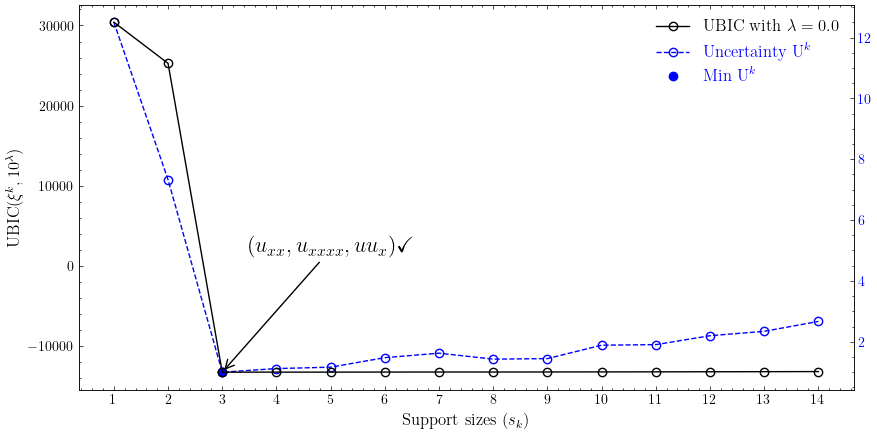

In [11]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    ax.annotate('$(u_{xx}, u_{xxxx}, uu_{x})\checkmark$', fontsize=16, 
                 xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
                 xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+15000), 
                 arrowprops={'arrowstyle': '->'})
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {abs(round(last_lam,2))}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper right', fontsize=12)
    
    plt.show()

#### Percent coefficient error

In [12]:
evaluate_coefficients(np.linalg.lstsq(X_pre[:, best_subsets[best_bc]], 
                                      y_pre, rcond=None)[0].flatten())

(0.38132739991078024, 0.07431223141770352)